In [1]:
%load_ext watermark

In [2]:
import re
from itertools import chain
from pathlib import Path
from tqdm.auto import tqdm
import pynini as pn

In [3]:
dict_dir = Path("/Users/seantyh/Documents/MFA/pretrained_models/dictionary/")
dict_name = "mandarin_taiwan_mfa_redelvar.dict"
dtext = (dict_dir / dict_name).read_text()

In [4]:
ipa_list = []
for ln in dtext.split("\n"):
    fields = ln.strip().split("\t")
    if len(fields) < 6:
        continue
    ipa_x = fields[5]
    word = fields[0]
    if ipa_x in ("sil", "spn") or \
       ipa_x.startswith("#"):
        continue
    ipa_list.append((word, ipa_x))
len(ipa_list)    

616593

In [5]:
def tokenize(x):
    toks = x.split()
    outs = []
    for tok_x in toks:
        tone = re.findall("[\u02e5-\u02e9]+", tok_x)
        if tone:
            outs.append(tok_x.replace(tone[0], ""))
            outs.append(tone[0])
        else:
            outs.append(tok_x)
    return outs

token_set = set(chain.from_iterable(
                tokenize(x) 
                for x in map(lambda x: x[1], ipa_list)))

In [6]:
len(token_set)

48

In [7]:
tone_set = set(x for x in token_set if re.match("[\u02e5-\u02e9]+", x))
tone_set

{'˥˥', '˥˩', '˦', '˧˥', '˨', '˨˩˦', '˩'}

In [8]:
def fsa_tokenize(instr): 
    return " ".join(f"[{x}]" 
                    for x in tokenize(instr))

def accep(t):
    a = pn.accep(t, token_type=sym)
    a.set_input_symbols(sym)
    return a

def postproc(s):
    s = re.sub(r"[\[\]]", "", s.strip())
    s = re.sub(r" ([\u02e5-\u02e9]+)", "\\1", s)
    return s

def decode_path(fst):
    fst.set_output_symbols(sym)
    sp = pn.shortestpath(fst).paths(input_token_type=sym, output_token_type=sym)
    return list(sp.ostrings())[0]

def make_syllables(syllstr):
    return [postproc(x) 
            for x in syllstr.split(",") 
            if x]

In [9]:
phone_set = token_set - tone_set
len(phone_set)

41

In [10]:
sym = pn.SymbolTable()
sym.add_symbol("(eps)", 0)
sym.add_symbol(",", 1)
for tok_x in token_set:
    sym.add_symbol(f"[{tok_x}]", sym.num_symbols())

In [11]:
coda_fsa = pn.union(accep("[n]"), accep("[ŋ]"))
phones_fsa = pn.union(*[accep(f"[{x}]") for x in phone_set])
tones_fsa = pn.union(*[accep(f"[{x}]") for x in tone_set])
boundary_fst = pn.cross(accep(""), accep(","))
er_fsa_1 = accep("[ɻ]")
er_fsa_2 = accep("[ʔ]") + accep("[o]") + tones_fsa + accep("[ɻ]") # all tones of 二
er_fsa_3 = accep("[o]") + tones_fsa + accep("[ɻ]") # all tones of 二 after onset deletion
er_fsa = pn.union(er_fsa_1, er_fsa_2, er_fsa_3)

In [12]:
syllable_fsa = phones_fsa.closure(1) + tones_fsa + coda_fsa.closure(0)
syllable_fsa = pn.union(syllable_fsa, er_fsa)
syllable_fsa.optimize()
syllable_fst = syllable_fsa + boundary_fst
pron_fst = syllable_fst.closure(1)
pron_fst.optimize()
pron_fst.set_input_symbols(sym)
pron_fst.set_output_symbols(sym)
pass  # suppress output

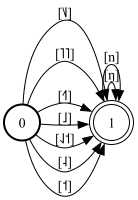

In [13]:
(tones_fsa.optimize()+coda_fsa).optimize()

In [14]:
flog = open("../data/charac_boundary.log", "w", encoding="UTF-8")
ipa_sylls = []
for word, ipa_x in tqdm(ipa_list):

    tok_str = fsa_tokenize(ipa_x)
    try:
        syllstr = decode_path(accep(tok_str) @ pron_fst)
    except:
        print(ipa_x)
        break
    sylls = make_syllables(syllstr)
    
    word_chk = word.replace("，", "")
    if len(word_chk) != len(sylls):
        flog.write(str((word, ipa_x, sylls)))
        flog.write("\n")
    
    ipa_sylls.append((word, ipa_x, " | ".join(sylls)))
flog.close()

  0%|          | 0/616593 [00:00<?, ?it/s]

## Output data

In [15]:
import pandas as pd
oframe = pd.DataFrame(ipa_sylls, columns="word ipa syllables".split())

In [16]:
out_path = Path("../data/") / Path(dict_name).with_suffix(".syll.tsv")

In [17]:
oframe.to_csv(out_path, sep="\t", index=False)

In [18]:
!sha1sum $out_path

bb6c0a5d02d79f6ade53de9da1fa7639a03c3d4c  ../data/mandarin_taiwan_mfa_redelvar.syll.tsv


In [19]:
oframe.head()

,word,ipa,syllables
0,㐌,i˧˥,i˧˥
1,㐖,ɕ j e˧˥,ɕ j e˧˥
2,㐖,j e˧˥,j e˧˥
3,㐖毒,ɕ j e˧˥ t u˧˥,ɕ j e˧˥ | t u˧˥
4,㐖毒,ɕ j e˧˥ u˧˥,ɕ j e˧˥ | u˧˥


## Watermarks

In [20]:
%watermark

Last updated: 2023-05-16T11:58:02.347120+02:00

Python implementation: CPython
Python version       : 3.10.10
IPython version      : 8.13.1

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 22.1.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit



In [21]:
%watermark --iversion

pandas: 2.0.1
pynini: 2.1.5
re    : 2.2.1

